In [34]:
%pip install scikit-learn
%pip install xgboost

import os
os._exit( 0 )


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


: 

In [2]:
import numpy as np
import pandas as pd

# these may be independently useful
demographic_variables = [ 'sex', 'age', 'distance_to_club' ]
behavioral_variables = [ 'visits', 'spend' ]

In [54]:
#
# This cell exists only to form a dataset, if you've got a CSV you can bypass it
#

months = [ 1, 2, 3, 4, 5, 6 ]
customers = 3000
active_threshold = -2

simulated_data = np.random.normal( size = ( len( months ) * customers, len( demographic_variables ) + len( behavioral_variables ) + 1 ) )
simulated_data = pd.DataFrame( simulated_data, columns = [ *demographic_variables, *behavioral_variables, 'active'] )
simulated_data = simulated_data.assign( customer_id = lambda _df: _df.index // len( months ) )
simulated_data = simulated_data.assign( month = months * customers )

simulated_data = simulated_data.assign( active = lambda _df: np.where( _df.active < active_threshold, 0, 1 ) )
initial_demos = simulated_data.query( 'month == 1' )[['customer_id',*demographic_variables]]
simulated_data = simulated_data.drop( demographic_variables, axis = 1 ).merge( initial_demos, on = 'customer_id' )
first_churn_month = simulated_data.query( 'active == 0' ).groupby( 'customer_id' )['month'].min().reset_index().rename( columns = { 'month': 'first_churn_month' } )
simulated_data = simulated_data \
    .merge( first_churn_month, on = 'customer_id', how = 'left' ) \
    .assign( first_churn_month = lambda _df: _df.first_churn_month.fillna( max( months ) + 1 ) ) \
    .assign( sex = lambda _df: np.where( _df.sex < 1e-1, 1, 0 ) ) \
    .query( 'month <= first_churn_month' )

In [55]:
#
# Merge the dataset on itself, last month
# Note that this assumes that demographics are stable
#
data = simulated_data
data = data \
    .assign( month = lambda _df: _df.month - 1 ) \
    .merge(
        data \
            [['customer_id','month',*behavioral_variables]] \
            .rename( columns = { column: f'last_{column}' for column in behavioral_variables } ),
        on = [ 'customer_id', 'month' ]
    ) \
    .assign( month = lambda _df: _df.month + 1 )

for column in behavioral_variables:
    data = data.assign( **{ f'delta_{column}': lambda _df: _df[column] - _df[f'last_{column}'] } )
    data = data.assign( **{ f'delta_{column}_pct': lambda _df: _df[f'delta_{column}'] / _df[f'last_{column}'] } )



In [58]:
#
# Train a model
#
from sklearn.utils import class_weight
import xgboost

independent_variables = [
    *demographic_variables,
    *[ f'last_{variable}' for variable in behavioral_variables ],
    *[ f'delta_{variable}' for variable in behavioral_variables ],
    *[ f'delta_{variable}_pct' for variable in behavioral_variables ]
]
dependent_variables = 'active'

xgb = xgboost.XGBClassifier()
balanced_weights = class_weight.compute_sample_weight( class_weight = 'balanced', y = data[dependent_variables] )
xgb_res = xgb.fit( data[independent_variables], data[dependent_variables], sample_weight = balanced_weights )

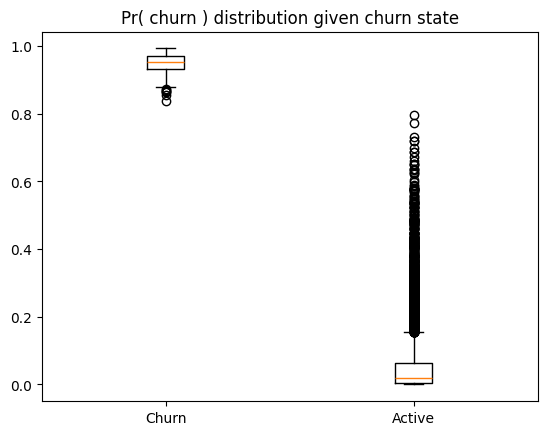

In [59]:
#
# Use it
#
import matplotlib.pyplot as plot

pr_churn = xgb_res.predict_proba( data[independent_variables] )[:,0]
predictions = data[['customer_id','month','active']].assign( pr_churn = pr_churn )

plot.boxplot( [ predictions.query( f'active == {active}' ).pr_churn for active in [ 0, 1 ] ], labels = [ 'Churn', 'Active' ] )
plot.title( 'Pr( churn ) distribution given churn state' )
plot.show()